# cnn-feature-hierarhcy

In [2]:
import torch

def pick_device() -> torch.device:
    if torch.backends.mps.is_available():
        print("Using mps backend")
        return torch.device("mps")
    if torch.cuda.is_available():
        print("Using cuda backend")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        return torch.device("cuda")
    print('No GPU available, using the CPU.')
    return torch.device("cpu")

device = pick_device()  #torch.device("cpu")
pin_memory = True if device.type != 'cpu' else False
if device.type != 'cpu':
    print(f"Device: {torch.cuda.get_device_name(device=device)}")
    print(torch.cuda.memory_summary(device=device))


Using cuda backend
There are 1 GPU(s) available.
Device: NVIDIA GeForce GTX 1070
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B 

# Dataset

In [3]:
from datasets import load_dataset, load_dataset_builder, DatasetDict, Dataset

DATASET = "cifar10"

ds_builder = load_dataset_builder(DATASET)
print("Features: ", ds_builder.info.features.keys())
labels = ds_builder.info.features['label']
print("Labels: ", labels.names)

train_dataset = load_dataset(DATASET, split="train")
print(f"Dataset size: {len(train_dataset)}")
val_dataset = load_dataset(DATASET, split="test")

NUM_CLASSES = len(labels.names)
print(f"Num classes: {NUM_CLASSES}")


Features:  dict_keys(['img', 'label'])
Labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset size: 50000
Num classes: 10


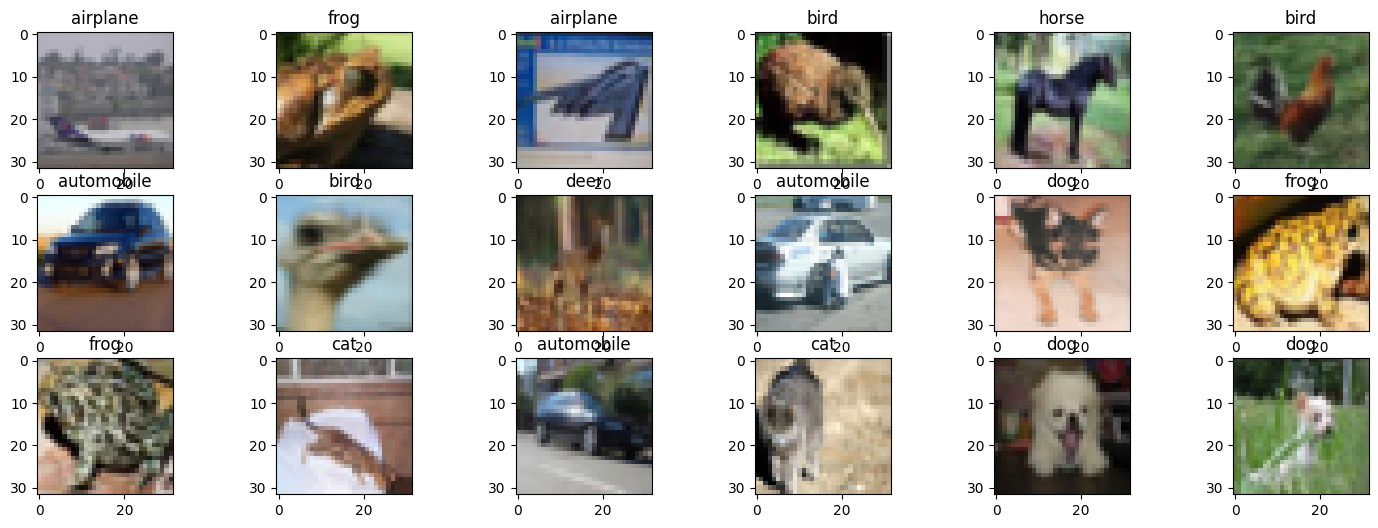

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

it = iter(train_dataset)

nrows, ncols = 3, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
for i in range(0, nrows):
    for j in range(0, ncols):
        sample = next(it)
        ax =  axes[i][j]
        ax.axis('on')
        ax.set_title(labels.names[sample['label']])
        ax.imshow(sample['img'])
plt.show()

# Preprocess Dataset

Convert the dataset to the format needed for ResNet.

In [5]:
from torchvision import transforms

CACHE_FILE_PREFIX = f"data/resnet-{DATASET}"

def preprocess_dataset(ds: Dataset, split: str) -> Dataset:
    # Format expected by ResNet https://pytorch.org/hub/pytorch_vision_resnet/
    # transforms.Lambda(lambda x: x.to(device)),
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def transform(item: dict) -> dict:
        item['img_tensor'] = preprocess(item['img'])
        return item

    return ds.map(
        transform,
        remove_columns="img",
        cache_file_name=f"{CACHE_FILE_PREFIX}-{split}.cache",
        desc=f"Resnet preprocessing ({split})",
        num_proc=4,
        writer_batch_size=64,
    )

tr_processed_dataset = preprocess_dataset(train_dataset, 'train')
print(f"Train size: {len(tr_processed_dataset)}")
val_processed_dataset = preprocess_dataset(val_dataset, 'val')
print(f"Val size: {len(val_processed_dataset)}")


Train size: 50000
Val size: 10000


In [23]:
from torch.utils.data import DataLoader

MINI_BATCH_SZ = 256

def data_loader(ds: Dataset) -> DataLoader:
    return DataLoader(
        ds.with_format('torch', dtype=torch.float32),
        batch_size=MINI_BATCH_SZ,
        pin_memory=pin_memory,
        pin_memory_device=device.type
    )

torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=device, abbreviated=True))

tr_loader = data_loader(tr_processed_dataset)
val_loader = data_loader(val_processed_dataset)


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 377899 KiB |   3087 MiB |   2408 GiB |   2408 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 377899 KiB |   3087 MiB |   2408 GiB |   2408 GiB |
|---------------------------------------------------------------------------|
| Requested memory      | 373521 KiB |   3085 MiB |   2406 GiB |   2405 GiB |
|---------------------------------------------------------------

# Training

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import torchvision

import time


# Example using a pre-trained model with 1k classes
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

# Create an untrained model
NUM_CLASSES = len(labels.names)

model = torchvision.models.resnet18(num_classes=NUM_CLASSES)
model.to(device)

lr = 0.01
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [26]:
from tqdm.notebook import tqdm

def train(model: nn.Module, Xb: torch.tensor, Yb: torch.tensor) -> tuple[torch.tensor, torch.tensor, int, int]:
    # Labels are a class integer. The model output contains one value
    # for the number of classes.
    label = Yb
    Yb = F.one_hot(Yb.long(), num_classes=NUM_CLASSES).float()

    model.zero_grad()
    logits = model.forward(Xb)
    loss = F.cross_entropy(logits, Yb)
    loss.backward()

    with torch.no_grad():
        logits_classes = torch.argmax(logits, dim=1)
        total = Yb.size(0)
        correct = (logits_classes == label).sum().cpu()

    return (logits, loss, total, correct)


def evaluate(model: nn.Module, Xb: torch.tensor, Yb: torch.tensor) -> tuple[int, int]:
    """Process a training batch and return total and correct"""
    # Labels are a class integer. The model output contains one value
    # for the number of classes.
    label = Yb
    Yb = F.one_hot(Yb.long(), num_classes=NUM_CLASSES).float()

    logits = model.forward(Xb)
    loss = F.cross_entropy(logits, Yb)

    lossi.append(loss.item())

    logits_classes = torch.argmax(logits, dim=1)
    total = Yb.size(0)
    correct = (logits_classes == label).sum()
    return (total, correct)


def eval_epoch(model: nn.Module, ds: DataLoader) -> tuple[int, int]:

    total = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        pbar = tqdm(enumerate(ds))
        pbar.reset(total=len(ds.dataset))
        for step, batch in pbar:
            Xb = batch['img_tensor'].to(device)
            Yb = batch['label'].to(device)

            (t, c) = evaluate(model, Xb, Yb)
            total += t
            correct += c

            pbar.update(Yb.size(0))
            if step % 10 == 0:
                accuracy = (correct / total) * 100
                mem_alloc = torch.cuda.memory_allocated(device=device)
                pbar.set_description(f"Eval Step {step}: Accuracy: {accuracy:0.2f}% Mem: {mem_alloc}")


    return total, correct

In [27]:
for epoch in range(20):
    model.train()

    lossi: list[float] = []
    accuracyi: list[float] = []
    t0_epoch = time.time()

    pbar = tqdm(enumerate(tr_loader))
    pbar.reset(total=len(tr_loader.dataset))
    
    with torch.enable_grad():
        for step, batch in pbar:
            Xb = batch['img_tensor'].to(device)
            Yb = batch['label'].to(device)

            logits, loss, total, correct = train(model, Xb, Yb)
            opt.step()

            lossi.append(loss.item())

            accuracy = (correct / total) * 100
            accuracyi.append(accuracy)

            pbar.update(Yb.size(0))
            if step > 0 and step % 10 == 0:
                #pbar.set_description(f"{step}: {loss.item():0.3f} | {accuracy:0.2f}")
                mean_loss = np.mean(lossi[-10:])
                mean_accuracy = np.mean(accuracyi[-10:])
                mem_alloc = torch.cuda.memory_allocated(device=device)
                pbar.set_description(f"Train Step {step}: Loss: {mean_loss:0.2f} Accuracy: {mean_accuracy:0.2f}% Mem: {mem_alloc}")
    
    max_accuracy = np.max(accuracyi)
    mean_accuracy = np.mean(accuracyi)
    print(f"Train Epoch {epoch}: Accuracy Mean: {mean_accuracy:0.2f}% | Max: {max_accuracy:0.2f}%")

    total, correct = eval_epoch(model, val_loader)
    accuracy = (correct / total) * 100
    print(f"Eval Epoch {epoch}: Accuracy: {accuracy:0.2f}%")



0it [00:00, ?it/s]

Train Epoch 0: Accuracy Mean: 39.92% | Max: 58.98% | Recent: 39.92%


0it [00:00, ?it/s]

In [55]:

pbar = tqdm(enumerate(val_loader))
total = 0
correct = 0

model.eval()

with torch.no_grad():

    for step, batch in pbar:
        Xb = batch['img'].to(device)
        Yb = batch['label'].to(device)


        (t, c) = evaluate(model, Xb, Yb)
        total += t
        correct += c

        if step % 10 == 0:
            accuracy = (correct / total) * 100
            pbar.set_description(f"{accuracy:2.2f}% - {correct} of {total}")

60.45% - 1654 of 2736: : 173it [00:16, 10.76it/s]


KeyboardInterrupt: 

# Work Log

Training resnet model as an initial step of getting a working rig.
- After first training iteration: 51%
- After second training iteration: 59%

Note: Resnet-18 gets a top-1 accuracy 70% accuracy on imagenet 1k